In [1]:
import os
import sys


import numpy as np
import pandas as pd
import torch

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
BASE_DIR = ".."
MODEL_BASE_DIR = f"{BASE_DIR}/best_models"
DATA_DIR = f"{BASE_DIR}/nbdata"
os.makedirs(MODEL_BASE_DIR,exist_ok=True)
os.makedirs(DATA_DIR,exist_ok=True)
sys.path.append(BASE_DIR)

In [3]:
import captum
captum.__version__

'0.4.0'

In [4]:
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

from src.featurizers import (
    MorganFeaturizer,
    ProtBertFeaturizer,
    ProseFeaturizer,
    BindPredict21Featurizer,
    DSCRIPTFeaturizer,
    ConcatFeaturizer
)

from src.architectures import SimpleCoembedding
from src.utils import set_random_seed

---

In [5]:
from torch import nn

class DTI_Model(nn.Module):
    def __init__(self,
                 drug_shape = 2048,
                 target_shape = 100,
                 latent_dimension = 1024,
                 latent_activation = nn.ReLU
                ):
        super().__init__()
        self.drug_shape = drug_shape
        self.target_shape = target_shape

        self.drug_projector = nn.Sequential(
            nn.Linear(self.drug_shape, latent_dimension),
            latent_activation()
        )

        self.target_projector = nn.Sequential(
            nn.Linear(self.target_shape, latent_dimension),
            latent_activation()
        )

        self.activator = nn.CosineSimilarity()

    def forward(self, drug, target):
        drug_projection = self.drug_projector(drug)
        target_projection = self.target_projector(target)

        return self.activator(drug_projection, target_projection)

In [6]:
set_random_seed(61998)

In [7]:
task_dir = "../dataset/DAVIS/"

In [8]:
df = pd.read_csv(f"{task_dir}/test.csv",index_col=0)
# df = pd.read_csv(f'{BASE_DIR}/dataset/BindingDB/test.csv',index_col=0)

In [9]:
device = torch.device(5)

In [10]:
drug_featurizer = MorganFeaturizer(save_dir=task_dir)
target_featurizer = ConcatFeaturizer([ProseFeaturizer,DSCRIPTFeaturizer],save_dir=task_dir)

In [11]:
drug_featurizer.to(device)
target_featurizer.to(device)

In [12]:
drug_featurizer.preload(df['SMILES'].unique())
target_featurizer.preload(df['Target Sequence'].unique())

100%|█████████████████████████████████████████████████████████████████████████████████| 379/379 [00:00<00:00, 3646.29it/s]


In [13]:
baseline_prot = torch.zeros(target_featurizer.shape).unsqueeze(0).to(device)
baseline_mol = torch.zeros(drug_featurizer.shape).unsqueeze(0).cuda(device)

In [14]:
from src.architectures import SimpleCosine

# model = SimpleCoembedding(
#     drug_featurizer.shape,
#     target_featurizer.shape,
#     1024
# )
model = DTI_Model(
    drug_featurizer.shape,
    target_featurizer.shape,
    1024
)
sd = torch.load("../best_models/drug_featurizer:MorganFeaturizer_replicate:0_target_featurizer:ProseFeaturizer_task:davis/test_dscript_cat_best_model.pt")
model.load_state_dict(sd)
model = model.to(device)
model = model.eval()
# model = torch.load(f'/afs/csail.mit.edu/u/s/samsl/Work/Applications/MolTrans/Davis_SimpleCosine_Morgan_ProtBert_DSCRIPT_cat_rep0_best_model.sav').to(device).eval()

In [15]:
df

,SMILES,Target Sequence,Label,drug_encoding,target_encoding
0,CN(C)CC1CCN2C=C(C3=CC=CC=C32)C4=C(C5=CN(CCO1)C...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,[0. 0. 0. ... 0. 0. 0.],[8.483 5.827 3.599 ... 0. 0. 0. ]
1,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,MAEKQKHDGRVKIGHYVLGDTLGVGTFGKVKIGEHQLTGHKVAVKI...,0,[0. 0. 0. ... 0. 0. 0.],[5.978 5.797 2.899 ... 0. 0. 0. ]
2,CNC(=O)C1=CC=CC=C1SC2=CC3=C(C=C2)C(=NN3)C=CC4=...,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...,0,[0. 1. 0. ... 0. 0. 0.],[6.789 5.222 3.525 ... 0. 0. 0. ]
3,CCN(CC)CCNC(=O)C1=C(NC(=C1C)C=C2C3=C(C=CC(=C3)...,MTSSLQRPWRVPWLPWTILLVSTAAASQNQERLCAFKDPYQQDLGI...,0,[0. 0. 0. ... 0. 0. 0.],[5.684 5.588 6.551 ... 0. 0. 0. ]
4,CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...,MGPEALSSLLLLLLVASGDADMKGHFDPAKCRYALGMQDRTIPDSD...,1,[0. 0. 0. ... 0. 0. 0.],[7.996 7.667 3.286 ... 0. 0. 0. ]
...,...,...,...,...,...
6006,CC1CCN(CC1N(C)C2=NC=NC3=C2C=CN3)C(=O)CC#N,MGHQESPLARAPAGGAAYVKRLCKGLSWREHVESHGSLGAQASPAS...,0,[0. 0. 1. ... 0. 0. 0.],[13.858 9.551 2.809 ... 0. 1. 0. ]
6007,CC1=CC=C(C=C1)N2C(=CC(=N2)C(C)(C)C)NC(=O)NC3=C...,MEEEGGSSGGAAGTSADGGDGGEQLLTVKHELRTANLTGHAEKVGI...,0,[0. 0. 0. ... 0. 0. 0.],[6.359 3.99 3.616 ... 0. 0. 0. ]
6008,CC1=CC(=C(C=C1)F)NC(=O)NC2=CC=C(C=C2)C3=C4C(=C...,MLLRSAGKLNVGTKKEDGESTAPTPRPKVLRCKCHHHCPEDSVNNI...,0,[0. 0. 0. ... 0. 0. 0.],[3.984 6.175 3.187 ... 0. 0. 0. ]
6009,CC1=C(NC(=C1C(=O)N2CCCC2CN3CCCC3)C)C=C4C5=C(C=...,MAGDLSAGFFMEELNTYRQKQGVVLKYQELPNSGPPHDRRFTFQVI...,0,[0. 0. 0. ... 0. 0. 0.],[5.263 4.483 4.483 ... 0. 0. 0. ]


In [16]:
ig = DeepLift(model)

In [17]:
model

DTI_Model(
  (drug_projector): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): ReLU()
  )
  (target_projector): Sequential(
    (0): Linear(in_features=6265, out_features=1024, bias=True)
    (1): ReLU()
  )
  (activator): CosineSimilarity()
)

In [19]:
pattr = []
for (_, r) in tqdm(df.iterrows(),total=len(df)):
    prot_lift = target_featurizer(r['Target Sequence']).unsqueeze(0)
    mol_lift = drug_featurizer(r['SMILES']).unsqueeze(0)
    inp = (mol_lift, prot_lift)
    base = (baseline_mol,baseline_prot)
    target = torch.tensor(r['Label']).unsqueeze(0).unsqueeze(0)
    (_, prot_attributions), _ = ig.attribute((mol_lift, prot_lift), (baseline_mol,baseline_prot), return_convergence_delta=True)
    pattr.append(prot_attributions.detach().cpu().squeeze())

  0%|          | 0/6011 [00:00<?, ?it/s]

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
prot_attr = torch.stack(pattr,0).mean(dim=0).detach().cpu()

In [22]:
# attr_trans = torch.softmax(prot_attr,0).unsqueeze(0)
attr_trans = prot_attr.unsqueeze(0)

In [24]:
last_size = 100

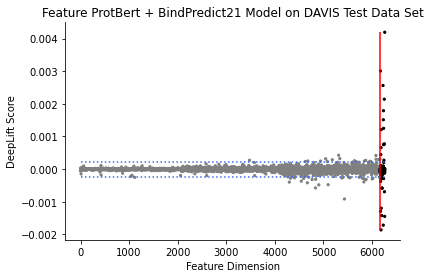

In [25]:
plt.scatter(np.arange(target_featurizer.shape), attr_trans,s=5,color=['gray' for i in range(target_featurizer.shape-last_size)]+['black' for i in range(last_size)])
plt.vlines(target_featurizer.shape-last_size,attr_trans.min(), attr_trans.max(),color='r')
plt.hlines(attr_trans.mean() + 2*attr_trans.std(),0,target_featurizer.shape,color='royalblue',linestyles='dotted')
plt.hlines(attr_trans.mean() - 2*attr_trans.std(),0,target_featurizer.shape,color='royalblue',linestyles='dotted')
plt.xlabel('Feature Dimension')
plt.ylabel('DeepLift Score')
plt.title('Feature ProtBert + BindPredict21 Model on DAVIS Test Data Set')
sns.despine()
# plt.savefig('esm_dscript_cat_bindingdb_deeplift_attributions.svg')
plt.show()